# Imports

In [5]:
%reload_ext autoreload
%autoreload 2


# import pickle
from plots import (
    MAX_TABLE_SIZE,
    make_table_avg,
    make_perf_table,
)
from utils import load_pickle
from generating_data.utils_for_notebooks import merge_methods
import pandas as pd
from IPython.display import display
import sys
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy import stats
import logging
import subprocess


FIGURES_FOLDER = './tmp/NeurIPS_2025_Accelerated-Model-Evaluation-by-Using-Similarities-in-Prediction-Space/figures'
N_SAMPLES_FIGURE_FOLDER = os.path.join(FIGURES_FOLDER, 'num_samples')
os.makedirs(FIGURES_FOLDER, exist_ok=True)

# Functions

In [6]:
def prepare_mae(mae_value):
    if mae_value is None or mae_value == float('nan'):
        return float('nan')
    else:
        return round(mae_value * 100, 2)

def prepare_rank(rank_value):
    if rank_value is None or rank_value == float('nan'):
        return float('nan')
    else:
        return round(rank_value, 3)

def make_table_1(data_for_table_1):

    assert len(data_for_table_1) == 4 # mae and rank for mmlu and hellaswag

    rows = []
    mmlu_maes, num_anchors_mmlu_maes = data_for_table_1[0]
    mmlu_ranks, num_anchors_mmlu_ranks = data_for_table_1[1]
    hellaswag_maes, num_anchors_hellaswag_maes = data_for_table_1[2]
    hellaswag_ranks, num_anchors_hellaswag_ranks = data_for_table_1[3]
    assert num_anchors_mmlu_maes == num_anchors_mmlu_ranks == num_anchors_hellaswag_maes == num_anchors_hellaswag_ranks
    num_anchors = num_anchors_mmlu_maes

    if hellaswag_maes is None:
        hellaswag_maes = mmlu_maes.copy()
        hellaswag_maes.loc[:,:] = float('nan')
    if hellaswag_ranks is None:
        hellaswag_ranks = mmlu_ranks.copy()
        hellaswag_ranks.loc[:,:] = float('nan')

    rows.append([ # headers
        "Approach",
        "Condensation", # type
        "Condensation", # num_anchors
        "Prediction", # type
        "MMLU", # mae
        "MMLU", # rank
        "hellaswag", # mae
        "hellaswag", # rank
    ])
    rows.append([
        "",
        "type", # type
        "num_anchors", # num_anchors
        "type", # type
        "mae", # mae
        "rank", # rank
        "mae", # mae
        "rank", # rank
    ])
    rows.append([ # RANDOM direct eval
        "Baseline",
        "Random",
        num_anchors,
        "Eval",
        prepare_mae(mmlu_maes.loc["random"]["naive"]),
        prepare_rank(mmlu_ranks.loc["random"]["naive"]),
        prepare_mae(hellaswag_maes.loc["random"]["naive"]),
        prepare_rank(hellaswag_ranks.loc["random"]["naive"]),
    ])
    # tinyBenchmarks
    rows.append([ # Random gp-IRT
        "tinyBenchmarks",
        "Random",
        num_anchors,
        "gp-IRT",
        prepare_mae(mmlu_maes.loc["random"]["gpirt"]),
        prepare_rank(mmlu_ranks.loc["random"]["gpirt"]),
        prepare_mae(hellaswag_maes.loc["random"]["gpirt"]),
        prepare_rank(hellaswag_ranks.loc["random"]["gpirt"]),
    ])
    rows.append([ # anchor-IRT gp-IRT
        "tinyBenchmarks",
        "anchor-IRT",
        num_anchors,
        "gp-IRT",
        prepare_mae(mmlu_maes.loc["anchor-irt"]["gpirt"]),
        prepare_rank(mmlu_ranks.loc["anchor-irt"]["gpirt"]),
        prepare_mae(hellaswag_maes.loc["anchor-irt"]["gpirt"]),
        prepare_rank(hellaswag_ranks.loc["anchor-irt"]["gpirt"]),
    ])
    rows.append([ # anchor-correctness gp-IRT
        "tinyBenchmarks",
        "anchor-correctness",
        num_anchors,
        "gp-IRT",
        prepare_mae(mmlu_maes.loc["anchor"]["gpirt"]),
        prepare_rank(mmlu_ranks.loc["anchor"]["gpirt"]),
        prepare_mae(hellaswag_maes.loc["anchor"]["gpirt"]),
        prepare_rank(hellaswag_ranks.loc["anchor"]["gpirt"]),
    ])
    rows.append([ # Random KNN
        "Baseline",
        "Random",
        num_anchors,
        "kNN",
        prepare_mae(mmlu_maes.loc["random"]["KNN"]),
        prepare_rank(mmlu_ranks.loc["random"]["KNN"]),
        prepare_mae(hellaswag_maes.loc["random"]["KNN"]),
        prepare_rank(hellaswag_ranks.loc["random"]["KNN"]),
    ])
    rows.append([ # Random fit
        "Baseline",
        "Random",
        num_anchors,
        "fit",
        prepare_mae(mmlu_maes.loc["random"]["fit"]),
        prepare_rank(mmlu_ranks.loc["random"]["fit"]),
        prepare_mae(hellaswag_maes.loc["random"]["fit"]),
        prepare_rank(hellaswag_ranks.loc["random"]["fit"]),
    ])
    rows.append([
        "DISCO (ours)",
        "High PDS",
        num_anchors,
        "kNN",
        prepare_mae(mmlu_maes.loc["highest"]["KNN"]),
        prepare_rank(mmlu_ranks.loc["highest"]["KNN"]),
        prepare_mae(hellaswag_maes.loc["highest"]["KNN"]),
        prepare_rank(hellaswag_ranks.loc["highest"]["KNN"]),
    ])
    rows.append([
        "DISCO (ours)",
        "High PDS",
        num_anchors,
        "fit",
        prepare_mae(mmlu_maes.loc["highest"]["fit"]),
        prepare_rank(mmlu_ranks.loc["highest"]["fit"]),
        prepare_mae(hellaswag_maes.loc["highest"]["fit"]),
        prepare_rank(hellaswag_ranks.loc["highest"]["fit"]),
    ])

    # res["baseline"] = {
    #     "mae": 0.0,
    #     "rank": 0.0
    # }
    # res["ours"] = {
    df = pd.DataFrame(rows)

    # display(df)

    latex_str = make_table_1_latex(df)

    return df, latex_str


def make_table_1_latex(df):
        # Add column headers
    df.columns = ["Approach", "Type", "# Samples", "Type", "MAE", "Rank", "MAE", "Rank"]

    # Create LaTeX table content
    latex_str = "\\begin{table}[H]\n"
    latex_str += "\\centering\n\\small\n"
    latex_str += "\\begin{tabular}{c|cc|c|cc|cc}\n"
    latex_str += "\\toprule\n"
    latex_str += "\\multicolumn{1}{c}{\\textbf{Approach}}&\\multicolumn{2}{c}{\\textbf{Condensation}} & \\multicolumn{1}{c}{\\textbf{Prediction}} & \\multicolumn{2}{c}{\\textbf{MMLU}}& \\multicolumn{2}{c}{\\textbf{hellaswag}} \\\\\n"
    latex_str += "&Type & \\# \\negthinspace Samples & Type & {MAE}  &Rank& {MAE}  &Rank \\\\\n"
    latex_str += "\\toprule\n"

    # Process each row
    current_approach = ""
    for _, row in df.iterrows():
        if row["Approach"] == "Approach" or row["Approach"] == "":
            continue
        if row["Approach"] == current_approach:
            approach_str = ""
        else:
            approach_str = row["Approach"]
            current_approach = row["Approach"]

            # Add midrule before new approach except for first one
            if approach_str != "Baseline":
                latex_str += "\\midrule\n"

        # Format numbers
        mae_mmlu = "-" if pd.isna(row["MAE"].values[0]) else f"{float(row['MAE'].values[0]):.2f}"
        rank_mmlu = "-" if pd.isna(row["Rank"].values[0]) else f"{float(row['Rank'].values[0]):.3f}"
        mae_hellaswag = "-" if pd.isna(row["MAE"].values[1]) else f"{float(row['MAE'].values[1]):.2f}"
        rank_hellaswag = "-" if pd.isna(row["Rank"].values[1]) else f"{float(row['Rank'].values[1]):.3f}"

        # Bold best results
        if approach_str == "DISCO (ours)" and row["Type"].values[1] == "linear":
            mae_mmlu = f"\\textbf{{{mae_mmlu}}}"
            rank_mmlu = f"\\textbf{{{rank_mmlu}}}"

        latex_str += f"{approach_str}&{row['Type'].values[0]} & {row['# Samples']} & {row['Type'].values[1]} & {mae_mmlu} &{rank_mmlu} & {mae_hellaswag} &{rank_hellaswag} \\\\\n"

    latex_str += "\\bottomrule\n"
    latex_str += "\\end{tabular}\n"
    latex_str += "\\vspace{1em}\n"
    latex_str += "\\caption{Mean Absolute Error (MAE) for different sampling and prediction strategies. For question answering task on MMLU dataset [FIX]. \\joon{Add computational complexity info\nAdd hellaswag results, add ranking metric, add method from hellaswag.\n}}\n"
    latex_str += "\\label{tab:language-main}\n"
    latex_str += "\\end{table}"

    # Store LaTeX code in DataFrame metadata
    df.attrs['latex_table'] = latex_str
    return latex_str


def extract_data_for_table_1(source_df, num_anchors, lower_better, key="PDS type"):
    # Group by PDS type and calculate mean for each group
    df = source_df[num_anchors]
    # For debugging:
    # display(df)
    # if num_anchors == 100 and not lower_better:
    #     display(df)
    # print("DEBUG")

    # Keep rows with NaN PDS type and group the rest
    nan_rows = df[df[key].isna()]
    non_nan_rows = df[df[key].notna()]
    if lower_better:
        grouped_non_nan = non_nan_rows.groupby(key, as_index=(key=="PDS type")).min()
    else:
        grouped_non_nan = non_nan_rows.groupby(key, as_index=(key=="PDS type")).max()
    grouped_df = pd.concat([grouped_non_nan, nan_rows])

    # to_drop = ["GradientBoostingRegressor_200"]
    # to_drop = ['MLP3_e700_lr0.001', 'Ridge_10', 'Lasso_e-4', 'RandomForestRegressor_100']
    to_drop = ['MLP3_e700_lr0.001', 'Ridge_10', 'Lasso_e-4', "GradientBoostingRegressor_200"] # keep only Random Forest
    to_drop = [col for col in to_drop if col in grouped_df.columns]
    # print("DEBUG: Dropping", to_drop)
    grouped_df = grouped_df.drop(columns=to_drop)

    # Get the columns to find minimum across
    min_cols = ['MLP3_e700_lr0.001', 'Ridge_10', 'Lasso_e-4', 'RandomForestRegressor_100', 'GradientBoostingRegressor_200']
    min_cols = [col for col in min_cols if col in grouped_df.columns]

    # Find minimum value across specified columns and store in new 'linear' column
    if lower_better:
        grouped_df['fit'] = grouped_df[min_cols].min(axis=1)
    else:
        grouped_df['fit'] = grouped_df[min_cols].max(axis=1)

    # Drop the original columns
    grouped_df = grouped_df.drop(columns=min_cols)

    # Drop the stratified and #guiding_models columns since they're no longer meaningful after grouping
    for cols_to_drop in ['stratified', '#guiding_models', 'cirt', 'pirt']:
        if cols_to_drop == key:
            continue
        if cols_to_drop in grouped_df.columns:
            grouped_df = grouped_df.drop(cols_to_drop, axis=1)

    return grouped_df, num_anchors


def make_df_with_results(table_avg, table_std, bench, split):
    cur_methods_for_table = table_avg[bench][split].keys()

    df = make_perf_table(
        table_avg[bench][split],
        table_std[bench][split],
        methods=cur_methods_for_table,
    )

    pd.set_option('display.max_rows', MAX_TABLE_SIZE)
    pd.set_option('display.max_columns', MAX_TABLE_SIZE)
    pd.set_option(
        "display.max_colwidth", MAX_TABLE_SIZE
    )
    for num_samples in df.keys():
        # print("#anchor_points:", num_samples)
        # Reorder columns to put guiding models, PDS type, and stratified first
        cols = df[num_samples].columns.tolist()
        first_cols = ['#guiding_models', 'PDS type', 'stratified']
        other_cols = [col for col in cols if col not in first_cols]
        df[num_samples] = df[num_samples][first_cols + other_cols]

        # Replace all values in #guiding_models column with 382
        df[num_samples].loc[df[num_samples]['#guiding_models'] == 'all', '#guiding_models'] = 382

        # Sort rows by #guiding_models
        df[num_samples] = df[num_samples].sort_values(['PDS type', 'stratified', '#guiding_models'])

        # print(df[num_samples])

    # df[max(list(df.keys()))].to_csv(results_table_path)
    return df

# Read data

In [ ]:
def process_table_data(
    bench,
    split,
    filename_suffix,
    data,
    scenarios_to_skip,
    ordered,
    agg_type,
    table_avg_base,
    table_std_base,
    model_perf_base
):
    current_table_avg, current_table_std, current_model_perf = make_table_avg(
        bench,
        split,
        filename_suffix,
        data,
        scenarios_to_skip=scenarios_to_skip,
        ordered=ordered,
        return_perf_table=True,
        agg_type=agg_type
    )
    table_avg_base = merge_methods(table_avg_base, current_table_avg)
    table_std_base = merge_methods(table_std_base, current_table_std)
    model_perf_base = merge_methods(model_perf_base, current_model_perf)
    return table_avg_base, table_std_base, model_perf_base


# load needed results
results_suffixes = {
    "mmlu_fields": {

        "iid": {
            "ours": "_disagreement_best_47",
            "irt": "_disagreement_compare_with_irt43"
        },
        # "noniid": {
        #     "ours": "_disagreement_best_48",
        #     "irt": "_disagreement_compare_with_irt44"
        # } # Old
        "noniid": {
            "ours": "_disagreement_best_68",
            "irt": "_disagreement_compare_with_irt70"
        } # more n anchors (till 2000)
    },
    "hellaswag": {

        "iid": {
            "ours": "_disagreement_best_63",
            "irt": "_disagreement_best_63"
        },
        "noniid": {
            "ours": "_disagreement_best_64",
            "irt": "_disagreement_best_64"
        }
    },
    "num_models": {
        3: "_disagreement_best_57",
        10: "_disagreement_best_56",
        30: "_disagreement_best_55",
        100: "_disagreement_best_54",
        300: "_disagreement_best_53",
        382: "_disagreement_best_68"
    },
    "umap_pca": {
        "no_pca": "_disagreement_before_pca_15",
        "pca1": "_disagreement_umap_pca88",
        "pca2": "_disagreement_umap_pca87",
        "pca4": "_disagreement_umap_pca86",
        "pca8": "_disagreement_umap_pca85",
        "pca16": "_disagreement_umap_pca78",
        "pca32": "_disagreement_umap_pca77",
        "pca64": "_disagreement_umap_pca21",
        "pca128": "_disagreement_umap_pca23",
        # "pca256": "_disagreement_umap_pca25",
        "pca256": "_disagreement_best_68",
        "pca300": "_disagreement_umap_pca79",
        "umap64": "_disagreement_umap_pca27",
        "umap128": "_disagreement_umap_pca29",
        "umap256": "_disagreement_umap_pca31"
    },
    "prediction_strategy": {
        "linear": "_disagreement_before_pca_73",
        "mlps": "_disagreement_before_pca_82",
        "other": "_disagreement_best_68",
    }
}
# print("DEBUG: uncomment all except for num_models")
scenarios_to_skip = []
table_1_data = []
table_1_data_iid = []
figure_n_anchors_data = {}
umap_pca_dfs = {}
prediction_strategy_dfs = {}

table_avg_dict = {}
table_std_dict = {}
model_perf_dict = {}

for bench, per_bench in results_suffixes.items():
    if bench not in table_avg_dict:
        table_avg_dict[bench] = {}
        table_std_dict[bench] = {}
        model_perf_dict[bench] = {}
    # ordered = bench in ["mmlu_fields", "hellaswag", "num_models", "umap_pca"]
    ordered = True
    for agg_type in ["mae", "rank"]:

        if agg_type not in table_avg_dict[bench]:
            table_avg_dict[bench][agg_type] = {}
            table_std_dict[bench][agg_type] = {}
            model_perf_dict[bench][agg_type] = {}

        if bench in ["num_models", "umap_pca", "prediction_strategy"]:
            if agg_type == "mae" and bench not in ["umap_pca", "prediction_strategy"]:
                continue

            split = "noniid"
            real_bench = "mmlu_fields"

            factor_list = []
            for factor, filename_suffix in per_bench.items():

                table_avg_base = None
                table_std_base = None
                model_perf_base = None

                if factor not in table_avg_dict[bench]:
                    table_avg_dict[bench][factor] = {}
                    table_std_dict[bench][factor] = {}
                    model_perf_dict[bench][factor] = {}

                results_path = f'results/accs_{real_bench}_split-{split}_iterations-5{filename_suffix}.pickle'

                data = load_pickle(results_path)

                table_avg_base, table_std_base, model_perf_base = process_table_data(
                    real_bench,
                    split,
                    filename_suffix,
                    data,
                    scenarios_to_skip,
                    ordered,
                    agg_type,
                    table_avg_base,
                    table_std_base,
                    model_perf_base
                )

                table_avg_dict[bench][agg_type][factor] = table_avg_base
                table_std_dict[bench][agg_type][factor] = table_std_base
                model_perf_dict[bench][agg_type][factor] = model_perf_base

                df = make_df_with_results(table_avg_base, table_std_base, real_bench, split)

                if bench == "prediction_strategy":

                    filtered_df = df[100]

                    filtered_df = filtered_df[filtered_df['PDS type'] == 'highest']
                    if factor == "other":
                        if agg_type == "rank":
                            filtered_df = filtered_df.loc[filtered_df['RandomForestRegressor_100'].idxmax()].to_frame().T
                        else:
                            filtered_df = filtered_df.loc[filtered_df['RandomForestRegressor_100'].idxmin()].to_frame().T

                        filtered_df.drop(columns=['MLP3_e700_lr0.001'], inplace=True)
                    else:
                        assert factor in ["linear", "mlps"]
                        if agg_type == "rank":
                            filtered_df = pd.DataFrame([filtered_df.max()], index=['highest'])
                        else:
                            filtered_df = pd.DataFrame([filtered_df.min()], index=['highest'])

                        if factor == "linear":
                            filtered_df = filtered_df[["LinearRegression"]]
                        else:
                            assert factor == "mlps"
                            filtered_df = filtered_df[["MLP2_e200_lr0.001", "MLP3_e700_lr0.001"]]

                    cols_to_drop = ['PDS type', 'stratified', '#guiding_models']
                    cols_to_drop = [col for col in cols_to_drop if col in filtered_df.columns]
                    filtered_df.drop(columns=cols_to_drop, inplace=True)
                    factor_list.append(filtered_df)
                else:
                    grouped_df, _ = extract_data_for_table_1(df, num_anchors=100, lower_better=(agg_type == "mae"))
                    grouped_df = grouped_df[["fit"]].rename(columns={"fit": f"fit-{factor}"})
                    factor_list.append(grouped_df)

            if len(factor_list) > 0:

                factor_df = pd.concat(factor_list, axis=1)

                if bench == "num_models":
                    num_models_df = factor_df

                if bench == "prediction_strategy":
                    prediction_strategy_dfs[agg_type] = factor_df

                if bench == "umap_pca":
                    umap_pca_dfs[agg_type] = factor_df
        else:

            for split, per_split in per_bench.items():
                if split not in table_avg_dict[bench][agg_type]:
                    table_avg_dict[bench][agg_type][split] = {}
                    table_std_dict[bench][agg_type][split] = {}
                    model_perf_dict[bench][agg_type][split] = {}

                table_avg_base = None
                table_std_base = None
                model_perf_base = None
                for method in [
                    "ours",
                    "irt"
                ]:

                    filename_suffix = per_split[method]
                    results_path = f'results/accs_{bench}_split-{split}_iterations-5{filename_suffix}.pickle'
                    data = load_pickle(results_path)

                    table_avg_base, table_std_base, model_perf_base = process_table_data(
                        bench,
                        split,
                        filename_suffix,
                        data,
                        scenarios_to_skip,
                        ordered,
                        agg_type,
                        table_avg_base,
                        table_std_base,
                        model_perf_base
                    )

                table_avg_dict[bench][agg_type][split] = table_avg_base
                table_std_dict[bench][agg_type][split] = table_std_base
                model_perf_dict[bench][agg_type][split] = model_perf_base

                if split == "noniid":

                    df = make_df_with_results(table_avg_base, table_std_base, bench, split)
                    table_1_data.append(extract_data_for_table_1(df, num_anchors=100, lower_better=(agg_type == "mae")))
                    for num_anchors in df.keys():
                        if num_anchors not in figure_n_anchors_data:
                            figure_n_anchors_data[num_anchors] = []
                        figure_n_anchors_data[num_anchors].append(extract_data_for_table_1(df, num_anchors=num_anchors, lower_better=(agg_type == "mae")))
                    if agg_type == "rank":
                        ablation_strat, _ = extract_data_for_table_1(df, num_anchors=100, lower_better=(agg_type == "mae"), key="stratified")
                if split == "iid":
                    df_iid = make_df_with_results(table_avg_base, table_std_base, bench, split)
                    table_1_data_iid.append(extract_data_for_table_1(df_iid, num_anchors=100, lower_better=(agg_type == "mae")))

In [ ]:
prediction_strategy_dfs['mae']

# Table 1

In [ ]:
# table_1, latex_str = make_table_1(table_1_data + [(None, 100), (None, 100)])
table_1, latex_str = make_table_1(table_1_data)
display(table_1)
print(latex_str)

In [ ]:
# table_1, latex_str = make_table_1(table_1_data + [(None, 100), (None, 100)])
table_1_iid, latex_str_iid = make_table_1(table_1_data_iid)
display(table_1_iid)
print(latex_str_iid)

# Sensitivity: Num source models

In [ ]:
display(num_models_df.applymap(prepare_rank))

# Ablation: prediction strategy

In [ ]:
display(prediction_strategy_dfs['rank'])

In [ ]:
display(prediction_strategy_dfs['mae'])

# Ablation: dimensionality reduction

In [ ]:
display(umap_pca_dfs['rank'])

In [ ]:
display(umap_pca_dfs['mae'])

# Ablation: Stratification

In [ ]:
display(ablation_strat.loc[~ablation_strat['stratified'].isna(), ('fit', 'stratified')])

# Figure correlation with gt performance

In [30]:
# def plot_correlation_with_gt_performance(model_perf_dict, vision=False):
#     # if results == 'acc':
#     #     if agg == 'leaderboard':
#     # split = 'noniid'
#     split = 'noniid'
#     iteration = 1
#     number_item = 100
#     color_mappings = {}

#     alphas = {'random_naive':.4,'anchor_naive':.4,'anchor-irt_naive':.4,'anchor-irt_gpirt':.8}
#     markersize = {'random_naive':7,'anchor_naive':5,'anchor-irt_naive':5,'anchor-irt_gpirt':5}
#     names = {
#         'random_naive':'random',
#         'anchor-irt_naive':'IRT ',
#         'anchor_naive':'correctness',
#         'anchor-irt_gpirt':'IRT++',
#         'high-disagreement@100+nonstratified_GradientBoostingRegressor_200': 'High PDS/Linear',
#         'high-disagreement@100+nonstratified_RandomForestRegressor_100': 'High PDS/Random Forest'
#     }
#     plt.figure(figsize=(1.2*3.5,1.2*3))

#     # for i,bench in enumerate(['mmlu']): #benchs[:4]
#     for i,bench in enumerate(['mmlu_fields']): #benchs[:4]
#         # axis = {'lb':'avg. score', 'mmlu_fields':'accuracy', 'mmlu':'accuracy', 'helm':'mean win rate', 'alpaca':'win rate'}
#         # for method in ['anchor-irt_gpirt']: #

#         for method in [
#             # 'random_KNN'
#             # 'high-disagreement@100+nonstratified_GradientBoostingRegressor_200'
#             # 'high-disagreement+nonstratified_RandomForestRegressor_100'
#             'high-disagreement@100+nonstratified_RandomForestRegressor_100'
#         ]: #
#             # print(model_perf[bench][split][method])
#             if model_perf_dict is None:

#                 print("Using hardcoded data")
#                 if vision:
#                     x = [0.7518, 0.7879, 0.7507, 0.7676, 0.7784, 0.7747, 0.8336, 0.8271, 0.7577,
#         0.8461, 0.7945, 0.7992, 0.7800, 0.8084, 0.8358, 0.8520, 0.8047, 0.7854,
#         0.8086, 0.8327, 0.8374, 0.8083, 0.8352, 0.8130, 0.8045, 0.8645, 0.8561,
#         0.8445, 0.8623, 0.8595, 0.8350, 0.8404, 0.8636, 0.8486, 0.8654, 0.8197,
#         0.7710, 0.8391, 0.7858, 0.8389, 0.8391, 0.8364, 0.8008, 0.8346, 0.8621,
#         0.8432, 0.8027, 0.8604, 0.8494, 0.8380]
#                     y = [0.7607, 0.7811, 0.7600, 0.7930, 0.7831, 0.7709, 0.8251, 0.8158, 0.7627,
#         0.8412, 0.7994, 0.7827, 0.7745, 0.7942, 0.8267, 0.8511, 0.7952, 0.7765,
#         0.8052, 0.8259, 0.8415, 0.7973, 0.8294, 0.8090, 0.8025, 0.8620, 0.8557,
#         0.8522, 0.8568, 0.8663, 0.8253, 0.8228, 0.8568, 0.8418, 0.8586, 0.8245,
#         0.7698, 0.8409, 0.7884, 0.8321, 0.8406, 0.8397, 0.8126, 0.8301, 0.8648,
#         0.8454, 0.8078, 0.8532, 0.8511, 0.8423]
#                 else:
#                     x = [
#                         0.74505765, 0.57627382, 0.63675495, 0.65292241, 0.38084539, 0.64716621,
#                         0.60905773, 0.64266456, 0.77400765, 0.65963511, 0.45349487, 0.53712371,
#                         0.54949706, 0.65399154, 0.66097766, 0.70370242, 0.60520878, 0.56062885,
#                         0.62193137, 0.63557209, 0.39394311, 0.457429, 0.33628442, 0.60314194,
#                         0.63755535, 0.62489059, 0.62572778, 0.76651098, 0.61419194, 0.64899013,
#                         0.65274401, 0.50838601, 0.77287346, 0.70602432, 0.54623595, 0.74655344,
#                         0.71878393, 0.63617809, 0.76029052, 0.75110232
#                     ]
#                     y = [
#                         0.75731513, 0.60630879, 0.63863409, 0.66208239, 0.38429752, 0.64862158,
#                         0.6141397, 0.63641627, 0.72950503, 0.65494508, 0.39609827, 0.54465079,
#                         0.55145108, 0.64995122, 0.6629164, 0.7023732, 0.62522846, 0.54741339,
#                         0.63129268, 0.6264134, 0.41973213, 0.51171946, 0.35283553, 0.60904086,
#                         0.63357007, 0.62456882, 0.62493765, 0.76117544, 0.62270945, 0.63739011,
#                         0.64783929, 0.49335064, 0.75879076, 0.72244666, 0.56023766, 0.74885069,
#                         0.7073013, 0.6313948, 0.70250782, 0.75130385
#                     ]
#             else:
#                 model_perf = model_perf_dict[bench]['mae'][split]
#                 x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
#                 print(x)
#                 print(y)
#             method_name = names[method] if method in names else method
#             # label = "{:} (error={:.3f}, $r_S$={:.2f})".format(method_name, np.abs(x-y).mean(), stats.spearmanr(x,y).statistic)
#             label = "{:} ($r_S$={:.2f})".format(method_name, stats.spearmanr(x,y).statistic)
#             markersize = markersize[method] if method in markersize else 5
#             alpha = alphas[method] if method in alphas else 0.5
#             color = color_mappings[method] if method in color_mappings else 'black'
#             plt.plot(x, y, 'o', label = label, markersize=markersize,alpha=alpha, color=color)

#         plt.legend(fontsize=10, framealpha=.9)
#         #plt.title(titles[bench])
#         plt.plot([0,1],[0,1],'--r',lw=.5)
#         plt.grid(alpha=.2)
#         plt.xlabel('Ground truth performance', size=12)
#         plt.ylabel('Estimated performance', size=12)
#         plt.xlim(0,1)
#         plt.ylim(0,1)
#         tick_label_size = 11  # Example size, adjust as needed
#         plt.tick_params(axis='x', labelsize=tick_label_size)
#         plt.tick_params(axis='y', labelsize=tick_label_size)

#     plt.tight_layout()
#     if vision:
#         save_path = os.path.join(FIGURES_FOLDER, 'performance_correlation_imagenet.pdf')
#     else:
#         save_path = os.path.join(FIGURES_FOLDER, 'performance_correlation_mmlu.pdf')
#     plt.savefig(save_path, bbox_inches='tight', dpi=400, transparent=True)
#     plt.show()

In [ ]:
# plot_correlation_with_gt_performance(model_perf_dict)

In [ ]:
# plot_correlation_with_gt_performance(None)

In [ ]:
# plot_correlation_with_gt_performance(None, vision=True)

In [40]:
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from scipy import stats
# import sys
# import subprocess


def make_figure_language_scatterplot(model_perf_dict, vision=False):
    # Define absolute paths
    # script_dir = os.path.dirname(os.path.abspath(__file__))
    # repo_root = os.path.abspath(os.path.join(script_dir, "../.."))  # Go up two levels to get to repo root
    if vision:
        output_file = os.path.join(FIGURES_FOLDER, "vision_scatterplot/plot.pdf")
    else:
        output_file = os.path.join(FIGURES_FOLDER, "language_scatterplot/plot.pdf")
    method = 'high-disagreement@100+nonstratified_RandomForestRegressor_100'

    # print(f"Script directory: {script_dir}")
    # print(f"Repository root: {repo_root}")
    # print(f"Output will be saved to: {output_file}")

    # Since model_perf_dict is referenced but not defined, we'll just use the hardcoded values
    # that are already in the script
    # model_perf_dict = {
    #     'mmlu_fields': {
    #         'noniid': {
    #             'mae': {}  # This is referenced but not used in final plotting
    #         }
    #     }
    # }

    # hardcoded version
    split = 'noniid'
    iteration = 1
    number_item = 100
    color_mappings = {}

    alphas = {'random_naive':.3,'anchor_naive':.3,'anchor-irt_naive':.3,'anchor-irt_gpirt':.6}
    markersize = {'random_naive':9,'anchor_naive':7,'anchor-irt_naive':7,'anchor-irt_gpirt':7}
    names = {
        'random_naive':'random',
        'anchor-irt_naive':'IRT ',
        'anchor_naive':'correctness',
        'anchor-irt_gpirt':'IRT++',
        'high-disagreement@100+nonstratified_GradientBoostingRegressor_200': 'High PDS / Signature-GB (DISCO)',
        'high-disagreement@100+nonstratified_RandomForestRegressor_100': 'High PDS / Signature-RF (DISCO)'
    }
    plt.figure(figsize=(1.2*3.5,1.2*3))

    if vision:
        range_x = [0.7, 0.9]
        range_y = [0.7, 0.9]
    else:
        range_x = [0.3, 0.8]
        range_y = [0.3, 0.8]

    # for i,bench in enumerate(['mmlu']): #benchs[:4]
    for i,bench in enumerate(['mmlu_fields']): #benchs[:4]
        axis = {'lb':'avg. score', 'mmlu_fields':'accuracy', 'mmlu':'accuracy', 'helm':'mean win rate', 'alpaca':'win rate'}
        # for method in ['anchor-irt_gpirt']: #
        # model_perf = model_perf_dict[bench][split]['mae']

        # Plot the x=y line behind the points
        plt.plot(range_x, range_y, '--r', lw=.5, zorder=0)

        # for method in [
        #     # 'random_KNN'
        #     'high-disagreement@100+nonstratified_GradientBoostingRegressor_200'
        # ]: #
        # print(model_perf[bench][split][method])
        # x = [
        #     0.74505765, 0.57627382, 0.63675495, 0.65292241, 0.38084539, 0.64716621,
        #     0.60905773, 0.64266456, 0.77400765, 0.65963511, 0.45349487, 0.53712371,
        #     0.54949706, 0.65399154, 0.66097766, 0.70370242, 0.60520878, 0.56062885,
        #     0.62193137, 0.63557209, 0.39394311, 0.457429, 0.33628442, 0.60314194,
        #     0.63755535, 0.62489059, 0.62572778, 0.76651098, 0.61419194, 0.64899013,
        #     0.65274401, 0.50838601, 0.77287346, 0.70602432, 0.54623595, 0.74655344,
        #     0.71878393, 0.63617809, 0.76029052, 0.75110232
        # ]
        # y = [
        #     0.74162506, 0.58105963, 0.62999359, 0.65297844, 0.38183675, 0.64818,
        #     0.62059757, 0.6415032, 0.73112584, 0.65266202, 0.42390838, 0.54364333,
        #     0.55297843, 0.64760771, 0.66037917, 0.71506391, 0.62563429, 0.55669639,
        #     0.63069553, 0.62085096, 0.40288662, 0.48256168, 0.34233494, 0.6123069,
        #     0.6299206, 0.62039802, 0.61374431, 0.75969047, 0.62258986, 0.64948626,
        #     0.63557096, 0.48961551, 0.76773106, 0.68572294, 0.55060159, 0.74863011,
        #     0.71897123, 0.61933916, 0.70531546, 0.74709759
        # ]
        if model_perf_dict is None:
            print("Using hardcoded data")
            # x = [
            #     0.74505765, 0.57627382, 0.63675495, 0.65292241, 0.38084539, 0.64716621,
            #     0.60905773, 0.64266456, 0.77400765, 0.65963511, 0.45349487, 0.53712371,
            #     0.54949706, 0.65399154, 0.66097766, 0.70370242, 0.60520878, 0.56062885,
            #     0.62193137, 0.63557209, 0.39394311, 0.457429, 0.33628442, 0.60314194,
            #     0.63755535, 0.62489059, 0.62572778, 0.76651098, 0.61419194, 0.64899013,
            #     0.65274401, 0.50838601, 0.77287346, 0.70602432, 0.54623595, 0.74655344,
            #     0.71878393, 0.63617809, 0.76029052, 0.75110232
            # ]
            # y = [
            #     0.75731513, 0.60630879, 0.63863409, 0.66208239, 0.38429752, 0.64862158,
            #     0.6141397, 0.63641627, 0.72950503, 0.65494508, 0.39609827, 0.54465079,
            #     0.55145108, 0.64995122, 0.6629164, 0.7023732, 0.62522846, 0.54741339,
            #     0.63129268, 0.6264134, 0.41973213, 0.51171946, 0.35283553, 0.60904086,
            #     0.63357007, 0.62456882, 0.62493765, 0.76117544, 0.62270945, 0.63739011,
            #     0.64783929, 0.49335064, 0.75879076, 0.72244666, 0.56023766, 0.74885069,
            #     0.7073013, 0.6313948, 0.70250782, 0.75130385
            # ]
            if vision:
                # {
                #     "name": "Benjamin Plot Final",
                #     "type": "debugpy",
                #     "request": "launch",
                #     "program": "./tmp/model-selection/notebooks/plot_final.py",
                #     "args": [
                #         "--scoring_function",
                #         "mae",
                #         // "rank",
                #         "--linear",
                #         // "MLP",
                #         "RF",
                #         "--number_bootstraping_steps",
                #         // "5",
                #         "1",
                #         "--pca_comp",
                #         "256",
                #         "--num_anchor_sizes",
                #         "100",
                #         // "64",
                #         // "32",
                #         // "16",
                #         // "2",
                #         "--model_type",
                #         "timm",
                #         // "openclip",
                #         "--n_source_models",
                #         // "40",
                #         // "50",
                #         // "50",
                #         // "16",
                #         // "100",
                #         // "200",
                #         "349",
                #         // "75",
                #         // "--gpu_id",
                #         // "6"
                #     ],
                #     "console": "integratedTerminal"
                # },
                    x = [0.7518, 0.7879, 0.7507, 0.7676, 0.7784, 0.7747, 0.8336, 0.8271, 0.7577,
                        0.8461, 0.7945, 0.7992, 0.7800, 0.8084, 0.8358, 0.8520, 0.8047, 0.7854,
                        0.8086, 0.8327, 0.8374, 0.8083, 0.8352, 0.8130, 0.8045, 0.8645, 0.8561,
                        0.8445, 0.8623, 0.8595, 0.8350, 0.8404, 0.8636, 0.8486, 0.8654, 0.8197,
                        0.7710, 0.8391, 0.7858, 0.8389, 0.8391, 0.8364, 0.8008, 0.8346, 0.8621,
                        0.8432, 0.8027, 0.8604, 0.8494, 0.8380]
                    y = [0.7607, 0.7811, 0.7600, 0.7930, 0.7831, 0.7709, 0.8251, 0.8158, 0.7627,
                        0.8412, 0.7994, 0.7827, 0.7745, 0.7942, 0.8267, 0.8511, 0.7952, 0.7765,
                        0.8052, 0.8259, 0.8415, 0.7973, 0.8294, 0.8090, 0.8025, 0.8620, 0.8557,
                        0.8522, 0.8568, 0.8663, 0.8253, 0.8228, 0.8568, 0.8418, 0.8586, 0.8245,
                        0.7698, 0.8409, 0.7884, 0.8321, 0.8406, 0.8397, 0.8126, 0.8301, 0.8648,
                        0.8454, 0.8078, 0.8532, 0.8511, 0.8423]
            else:
                x = [0.74505765, 0.57627382, 0.63675495, 0.65292241, 0.38084539, 0.64716621,
                    0.60905773, 0.64266456, 0.77400765, 0.65963511, 0.45349487, 0.53712371,
                    0.54949706, 0.65399154, 0.66097766, 0.70370242, 0.60520878, 0.56062885,
                    0.62193137, 0.63557209, 0.39394311, 0.457429, 0.33628442, 0.60314194,
                    0.63755535, 0.62489059, 0.62572778, 0.76651098, 0.61419194, 0.64899013,
                    0.65274401, 0.50838601, 0.77287346, 0.70602432, 0.54623595, 0.74655344,
                    0.71878393, 0.63617809, 0.76029052, 0.75110232]
                y = [0.75731513, 0.60630879, 0.63863409, 0.66208239, 0.38429752, 0.64862158,
                    0.6141397, 0.63641627, 0.72950503, 0.65494508, 0.39609827, 0.54465079,
                    0.55145108, 0.64995122, 0.6629164, 0.7023732, 0.62522846, 0.54741339,
                    0.63129268, 0.6264134, 0.41973213, 0.51171946, 0.35283553, 0.60904086,
                    0.63357007, 0.62456882, 0.62493765, 0.76117544, 0.62270945, 0.63739011,
                    0.64783929, 0.49335064, 0.75879076, 0.72244666, 0.56023766, 0.74885069,
                    0.7073013, 0.6313948, 0.70250782, 0.75130385]
        else:

            model_perf = model_perf_dict[bench]['mae'][split]
            x,y = model_perf[bench][split]['truth'], model_perf[bench][split][method][number_item][:,iteration]
            print(x)
            print(y)
        method_name = names[method] if method in names else method

        # Calculate Spearman and Pearson correlations
        spearman_corr = stats.spearmanr(x, y).statistic
        pearson_corr = stats.pearsonr(x, y).statistic

        label = "{:}\nSpearman={:.3f}\nPearson={:.3f}".format(
            method_name,
            spearman_corr,
            pearson_corr
        )

        marker_size = markersize[method] if method in markersize else 7
        alpha = alphas[method] if method in alphas else 0.4
        color = color_mappings[method] if method in color_mappings else 'black'
        plt.plot(x, y, 'o', label=label, markersize=marker_size, alpha=alpha, color=color, markeredgewidth=0, zorder=1)

        # Add the correlation values as text in the plot
        plt.legend(fontsize=10, framealpha=0, frameon=False, handlelength=0, handletextpad=0, markerscale=0, loc='upper left')
        #plt.title(titles[bench])
        plt.grid(alpha=.2)
        plt.xlabel('True accuracy', size=12)
        plt.ylabel('Estimated accuracy', size=12)
        # if vision:
        #     plt.xlim(0.7, 0.9)
        #     plt.ylim(0.7, 0.9)
        # else:
        #     plt.xlim(0.3, 0.8)
        #     plt.ylim(0.3, 0.8)
        plt.xlim(range_x)
        plt.ylim(range_y)

        tick_label_size = 11  # Example size, adjust as needed
        plt.tick_params(axis='x', labelsize=tick_label_size)
        plt.tick_params(axis='y', labelsize=tick_label_size)

    plt.tight_layout()
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    plt.savefig(output_file, bbox_inches='tight', dpi=400, transparent=True)
    print(f"Plot saved to: {output_file}")

# # Crop the PDF using pdfcrop
# try:
#     subprocess.run(['pdfcrop', output_file, output_file], check=True)
#     print(f"PDF cropped successfully: {output_file}")
# except Exception as e:
#     print(f"Error cropping PDF: {e}")
#     print("If pdfcrop is not installed, you can install it with:")
#     print("  - On macOS: 'brew install texlive' or through MacTex")
#     print("  - On Linux: 'apt-get install texlive-extra-utils'")
#     print("  - On Windows: Install MiKTeX or TeX Live which includes pdfcrop")

In [ ]:
make_figure_language_scatterplot(model_perf_dict)

## Final

In [ ]:
make_figure_language_scatterplot(None)

## Final vision

In [ ]:
make_figure_language_scatterplot(None, vision=True)

# Figure: n_anchors

In [41]:
# def make_figure_n_anchors(figure_n_anchors_data):
#     maes = {}
#     ranks = {}
#     num_anchors_axis = []
#     for method in [
#         "DISCO + Random Forest (ours)",
#         "DISCO + kNN (ours)",
#         "Random + Eval",
#         "Random + Random Forest",
#         "Anchor-correctness + gp-IRT"
#     ]:
#         maes[method] = []
#         ranks[method] = []
#     if figure_n_anchors_data is None:
#         print("Using hardcoded data")
#         ranks = {
#             'DISCO + Random Forest (ours)': [0.96, 0.977, 0.981, 0.987, 0.977, 0.985, 0.984, 0.979],
#             'DISCO + kNN (ours)': [0.973, 0.975, 0.973, 0.972, 0.974, 0.957, 0.952, 0.95],
#             'Random + Eval': [0.574, 0.721, 0.865, 0.916, 0.944, 0.972, 0.988, 0.992],
#             'Random + Random Forest': [0.824, 0.866, 0.901, 0.933, 0.928, 0.932, 0.952, 0.959],
#             'Anchor-correctness + gp-IRT': [0.845, 0.882, 0.925, 0.927, 0.956, 0.974, 0.991, 0.996]}
#         maes = {
#             'DISCO + Random Forest (ours)': [2.05, 1.2, 1.16, 1.07, 1.08, 1.02, 0.93, 1.15],
#             'DISCO + kNN (ours)': [1.17, 1.29, 1.2, 1.31, 1.59, 1.53, 1.57, 1.56],
#             'Random + Eval': [14.28, 9.05, 4.62, 3.45, 2.45, 1.4, 0.92, 0.73],
#             'Random + Random Forest': [3.23, 2.57, 2.05, 1.81, 1.66, 1.59, 1.51, 1.55],
#             'Anchor-correctness + gp-IRT': [3.4, 2.62, 2.24, 2.08, 1.67, 1.46, 1.14, 0.82]}
#         num_anchors_axis = [10, 30, 60, 100, 200, 500, 1000, 2000]
#     else:
#         for num_anchors, data_for_table_1 in figure_n_anchors_data.items():
#             assert len(data_for_table_1) >= 2 # mae and rank for mmlu and possibly helm

#             mmlu_maes, num_anchors_mmlu_maes = data_for_table_1[0]
#             mmlu_ranks, num_anchors_mmlu_ranks = data_for_table_1[1]
#             # helm_maes, num_anchors_helm_maes = data_for_table_1[2]
#             # helm_ranks, num_anchors_helm_ranks = data_for_table_1[3]
#             assert num_anchors_mmlu_maes == num_anchors_mmlu_ranks == num_anchors

#             maes["DISCO + Random Forest (ours)"].append(prepare_mae(mmlu_maes.loc["highest"]["fit"]))
#             ranks["DISCO + Random Forest (ours)"].append(prepare_rank(mmlu_ranks.loc["highest"]["fit"]))

#             maes["DISCO + kNN (ours)"].append(prepare_mae(mmlu_maes.loc["highest"]["KNN"]))
#             ranks["DISCO + kNN (ours)"].append(prepare_rank(mmlu_ranks.loc["highest"]["KNN"]))

#             maes["Random + Eval"].append(prepare_mae(mmlu_maes.loc["random"]["naive"]))
#             ranks["Random + Eval"].append(prepare_rank(mmlu_ranks.loc["random"]["naive"]))

#             maes["Random + Random Forest"].append(prepare_mae(mmlu_maes.loc["random"]["fit"]))
#             ranks["Random + Random Forest"].append(prepare_rank(mmlu_ranks.loc["random"]["fit"]))

#             maes["Anchor-correctness + gp-IRT"].append(prepare_mae(mmlu_maes.loc["anchor"]["gpirt"]))
#             ranks["Anchor-correctness + gp-IRT"].append(prepare_rank(mmlu_ranks.loc["anchor"]["gpirt"]))
#             num_anchors_axis.append(num_anchors)
#     # Create line plot
#     plt.figure(figsize=(8, 5))

#     print(ranks)
#     print(maes)

#     for method, mae_values in maes.items():
#         plt.plot(num_anchors_axis, mae_values, marker='o', label=method)

#     plt.xlabel('Number of Anchors')
#     plt.ylabel('Mean Absolute Error (MAE)')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.title('MAE vs Number of Anchors by Method')
#     plt.yscale('log')
#     plt.xticks(num_anchors_axis)
#     plt.yticks(
#         [1.0, 1.1, 1.3, 1.5, 2.0, 3.0, 10.0],
#         ['1.0', '1.1', '1.3', '1.5', '2.0', '3.0', '10.0']
#     )
#     plt.xscale('log')

#     plt.figure(figsize=(8, 5))

#     for method, rank_values in ranks.items():
#         plt.plot(num_anchors_axis, rank_values, marker='o', label=method)

#     plt.xlabel('Number of Anchors')
#     plt.ylabel('Rank Correlation')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.title('Rank Correlation vs Number of Anchors by Method')
#     plt.xticks(num_anchors_axis)
#     plt.yticks(
#         [0.60, 0.70, 0.80, 0.90, 0.92, 0.95, 0.98, 1.00],
#         ['0.60', '0.70', '0.80', '0.90', '0.92', '0.95', '0.98', '1.00']
#     )
#     plt.xscale('log')

#     # Save MAE plot
#     plt.figure(1)  # Switch to first figure (MAE plot)
#     plt.savefig(os.path.join(FIGURES_FOLDER, 'num_samples', 'mae_vs_n_anchors.pdf'), bbox_inches='tight')

#     # Save rank correlation plot
#     plt.figure(2)  # Switch to second figure (rank plot)
#     plt.savefig(os.path.join(FIGURES_FOLDER, 'num_samples', 'rank_vs_n_anchors.pdf'), bbox_inches='tight')

#     return plt.gcf()


In [ ]:
# fig_n_anchors = make_figure_n_anchors(figure_n_anchors_data)

In [ ]:
# fig_n_anchors = make_figure_n_anchors(None)

In [43]:
def make_figure_n_anchors_hard_coded_v2(figure_n_anchors_data, vision=False):
    # Disable matplotlib debug logging
    # logging.getLogger('matplotlib').setLevel(logging.WARNING)
    # logger.debug("Starting to create figures")
    maes = {}
    ranks = {}
    num_anchors_axis = []

    # Set global font sizes
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 14,
        'axes.titlesize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
    })

    # Map methods to their corresponding entries in the data dictionaries
    method_mapping = {
        "Random / Direct evaluation": 'Random Eval',
        "Anchor-corr / gp-IRT (tinyBenchmarks)": 'Anchor-correctness gp-IRT',
        "Random / Signature-RF": 'Random Linear',
        "High PDS / Signature-kNN (DISCO)": 'DISCO-kNN (ours)',
        "High PDS / Signature-RF (DISCO)": 'DISCO-linear (ours)',
        "Synth High PDS / Signature-kNN": 'SynthDisco-kNN',
        "Synth High PDS / Signature-RF": 'SynthDisco-linear'
    }

    # Group the methods
    groups = {
        "Random": ["Random / Direct evaluation"],
        "Anchor-corr": ["Anchor-corr / gp-IRT (tinyBenchmarks)"],
        "Our Signature-RF": ["Random / Signature-RF"],
        "DISCO (ours)": ["High PDS / Signature-kNN (DISCO)", "High PDS / Signature-RF (DISCO)"],
        "SynthDisco (ours)": ["Synth High PDS / Signature-kNN", "Synth High PDS / Signature-RF"]
    }

    # Define style for each group
    group_styles = {
        "Random": {'colors': ['#999999'], 'markers': ['s'], 'linestyles': ['-'], 'zorder': 1},
        "Anchor-corr": {'colors': ['#6baed6'], 'markers': ['^'], 'linestyles': ['-'], 'zorder': 2},
        "Our Signature-RF": {'colors': ['#4daf4a'], 'markers': ['d'], 'linestyles': ['--'], 'zorder': 2, 'linewidth': 1.8},
        "DISCO (ours)": {'colors': ['#984ea3', '#e41a1c'], 'markers': ['*', 'o'], 'linestyles': ['--', '-'], 'zorder': 3, 'linewidth': 2.5},
        "SynthDisco (ours)": {'colors': ['#ff7f00', '#ffd700'], 'markers': ['p', 'h'], 'linestyles': [':', '-'], 'zorder': 3, 'linewidth': 2.5}
    }

    # Hard-coded data for ranks
    # logger.debug("Setting up ranks data")

    if figure_n_anchors_data is None:
        # ranks = {
        #     'DISCO-linear (ours)': [96.24, 98.01, 98.03, 98.58],
        #     'DISCO-kNN (ours)': [97.26, 97.54, 97.28, 97.21],
        #     'Random Eval': [57.43, 72.08, 86.5, 91.55],
        #     'Random Linear': [83.24, 90.38, 91.9, 94.23],
        #     'Anchor-correctness gp-IRT': [84.5, 88.15, 92.46, 92.72]
        # }
        if vision:
            # maes = {
            #     'DISCO-linear (ours)': [1.6626723, 1.2269022, 1.1592515, 0.9390764, 0.8198263, 0.7911803, 0.8819575],
            #     'DISCO-kNN (ours)': [2.0667491, 1.4785151, 1.4301536, 1.3766285, 1.1300134, 1.2013043, 1.193418],
            #     'Random Eval': [9.681250151615726, 5.533599708401648, 3.909717534530524, 3.0274022825760017, 2.13959480396796, 1.352944490532248, 0.9565703031492822],
            #     'Random Linear': [1.6737659, 1.4273933, 1.3264142, 1.0428056, 1.0327628, 0.8838942, 0.74985507],
            #     'SynthDisco-kNN': [2.597405, 1.9638726, 1.6768161, 1.6036117, 1.3911977, 1.2606151, 1.1339531],
            #     'SynthDisco-linear': [1.8060286, 1.2927089, 1.1922138, 0.9762102, 0.957412, 1.0087962, 1.0339066]
            # }
            maes = {
                'Random Linear': [1.50373, 1.0865085, 0.9915857, 0.8629104, 0.7566951, 0.6917509, 0.64477944],
                'DISCO-linear (ours)': [1.2859464, 0.8075779, 0.6761404, 0.63383444, 0.5754672, 0.52553443, 0.59167333],
                'DISCO-kNN (ours)': [1.2137138, 1.5206119, 1.3627751, 1.6751021, 2.2784082, 1.647633, 1.856449],
                'Random Eval': [9.681250151615726, 5.533599708401648, 3.909717534530524, 3.0274022825760017, 2.13959480396796, 1.352944490532248, 0.9565703031492822]
            }
            # maes = {'Random/kNN (Baseline)': [0.021159265, 0.017512003, 0.018385714, 0.017218536, 0.0218778, 0.02331265, 0.025205389], 'Random/Linear (Baseline)': [0.0150373, 0.010865085, 0.009915857, 0.008629104, 0.007566951, 0.006917509, 0.0064477944], 'High PDS/kNN (DISCO)': [0.018030612, 0.022057548, 0.024557952, 0.035991825, 0.025766527, 0.017256735, 0.019664077], 'High PDS/Linear (DISCO)': [0.012859464, 0.008075779, 0.006761404, 0.0063383444, 0.005754672, 0.0052553443, 0.0059167333], 'Synth PDS/kNN (SynthDISCO)': [0.02923632, 0.036475092, 0.03715183, 0.036436312, 0.03400816, 0.033296734, 0.02711102], 'Synth PDS/Linear (SynthDISCO)': [0.013693811, 0.0123940455, 0.0069891214, 0.0065507432, 0.0073945327, 0.0071438663, 0.0055248607], 'High PDS-2/Linear (DISCO)': [0.011176864, 0.0064783962, 0.0071110665, 0.0075336294, 0.0055139316, 0.0057684863, 0.005868318], 'High PDS-2/KNN (DISCO)': [0.012137138, 0.015206119, 0.013627751, 0.016751021, 0.022784082, 0.01647633, 0.01856449], 'High Pull-Probs (DISCO)': [0.016122734, 0.009798458, 0.008791154, 0.0070368564, 0.005790295, 0.0072943578, 0.00663993], 'Random/Eval (Baseline)': [0.09681250151615726, 0.05533599708401648, 0.03909717534530524, 0.030274022825760017, 0.0213959480396796, 0.01352944490532248, 0.009565703031492822]}
            # ranks = {
            #     'DISCO-linear (ours)': [0.727, 0.823, 0.884, 0.922, 0.952, 0.959, 0.951],
            #     'DISCO-kNN (ours)': [0.678, 0.784, 0.836, 0.844, 0.899, 0.893, 0.884],
            #     'Random Eval': [0.258, 0.422, 0.552, 0.652, 0.775, 0.890, 0.941],
            #     'Random Linear': [0.567, 0.709, 0.776, 0.819, 0.848, 0.843, 0.850],
            #     'SynthDisco-kNN': [0.506, 0.671, 0.784, 0.800, 0.851, 0.870, 0.893],
            #     'SynthDisco-linear': [0.708, 0.880, 0.901, 0.938, 0.930, 0.952, 0.951]
            # }
            ranks = {
                # 'Random/kNN (Baseline)': [0.6068464336218181, 0.7187308999070386, 0.7137128239143461, 0.8082054690516441, 0.6251058738843428, 0.6021541787509006, 0.578704454631964],
                'Random Linear': [0.7605918367346938, 0.9011020408163264, 0.9247142857142856, 0.9437551020408161, 0.9531836734693876, 0.9611020408163264, 0.9672857142857142],
                # 'DISCO-kNN (ours)': [0.8166614049638611, 0.7748734862544353, 0.5267926304646834, 0.1784811061093482, 0.4714401724195624, 0.8381817779245623, 0.7920220486532794],
                'DISCO-linear (ours)': [0.902530612244898, 0.9631428571428572, 0.9655918367346936, 0.9674693877551019, 0.9711020408163265, 0.9709591836734693, 0.9707142857142855],
                # 'Synth PDS/kNN (SynthDISCO)': [0.49582568722600884, 0.32209732675338987, 0.4188684132476704, 0.38986515641592756, 0.24146058604719062, 0.2512163308542809, 0.18253962624298897],
                # 'Synth PDS/Linear (SynthDISCO)': [0.8170612244897958, 0.8941020408163265, 0.9368775510204082, 0.9619591836734693, 0.9477346938775509, 0.9539795918367346, 0.9688163265306123],
                # 'High PDS-2/Linear (DISCO)': [0.9281632653061225, 0.9665918367346938, 0.964938775510204, 0.9655918367346938, 0.9754897959183673, 0.9664285714285714, 0.970673469387755],
                'DISCO-kNN (ours)': [0.8917714503897984, 0.8802887025723821, 0.8753931219687343, 0.8187685748050267, 0.8044177461724018, 0.7845794311922141, 0.7742949995788978],
                # 'High Pull-Probs (DISCO)': [0.767204081632653, 0.9397551020408162, 0.9487346938775509, 0.9603265306122448, 0.9733061224489795, 0.9699183673469387, 0.9627755102040816],
                'Random Eval': [0.25816054197272853, 0.4217618905335009, 0.5547143451986409, 0.6525096676237219, 0.7746531529721933, 0.8897868531585025, 0.9404500903784425]}
            # create maes dict as below, don't have gp-IRT, but two new keys: SynthDisco-kNN and SynthDisco-linear
            # Key is written below numbers right now, be careful
            num_anchors_axis = [10, 30, 60, 100, 200, 500, 1000]
        else:

            ranks = {'DISCO-linear (ours)': [0.96, 0.977, 0.981, 0.987, 0.977, 0.985, 0.984, 0.979], 'DISCO-kNN (ours)': [0.973, 0.975, 0.973, 0.972, 0.974, 0.957, 0.952, 0.95], 'Random Eval': [0.574, 0.721, 0.865, 0.916, 0.944, 0.972, 0.988, 0.992], 'Random Linear': [0.824, 0.866, 0.901, 0.933, 0.928, 0.932, 0.952, 0.959], 'Anchor-correctness gp-IRT': [0.845, 0.882, 0.925, 0.927, 0.956, 0.974, 0.991, 0.996]}

            # Hard-coded data for MAEs
            # logger.debug("Setting up MAEs data")
            # maes = {
            #     'DISCO-linear (ours)': [2.05, 1.22, 1.11, 1.04],
            #     'DISCO-kNN (ours)': [1.17, 1.29, 1.2, 1.31],
            #     'Random Eval': [14.28, 9.05, 4.62, 3.45],
            #     'Random Linear': [3.1, 2.4, 1.9, 1.59],
            #     'Anchor-correctness gp-IRT': [3.4, 2.62, 2.24, 2.08]
            # }
            maes = {'DISCO-linear (ours)': [2.05, 1.2, 1.16, 1.07, 1.08, 1.02, 0.93, 1.15], 'DISCO-kNN (ours)': [1.17, 1.29, 1.2, 1.31, 1.59, 1.53, 1.57, 1.56], 'Random Eval': [14.28, 9.05, 4.62, 3.45, 2.45, 1.4, 0.92, 0.73], 'Random Linear': [3.23, 2.57, 2.05, 1.81, 1.66, 1.59, 1.51, 1.55], 'Anchor-correctness gp-IRT': [3.4, 2.62, 2.24, 2.08, 1.67, 1.46, 1.14, 0.82]}

            num_anchors_axis = [10, 30, 60, 100, 200, 500, 1000, 2000]
    else:
        assert not vision
        method_names = [
            "DISCO-linear (ours)",
            "DISCO-kNN (ours)",
            "Random Eval",
            "Random Linear",
            "Anchor-correctness gp-IRT"
        ]
        for method in method_names:
            maes[method] = []
            ranks[method] = []
        for num_anchors, data_for_table_1 in figure_n_anchors_data.items():
            assert len(data_for_table_1) >= 2 # mae and rank for mmlu and possibly helm

            mmlu_maes, num_anchors_mmlu_maes = data_for_table_1[0]
            mmlu_ranks, num_anchors_mmlu_ranks = data_for_table_1[1]
            # helm_maes, num_anchors_helm_maes = data_for_table_1[2]
            # helm_ranks, num_anchors_helm_ranks = data_for_table_1[3]
            assert num_anchors_mmlu_maes == num_anchors_mmlu_ranks == num_anchors

            maes[method_names[0]].append(prepare_mae(mmlu_maes.loc["highest"]["fit"]))
            ranks[method_names[0]].append(prepare_rank(mmlu_ranks.loc["highest"]["fit"]))

            maes[method_names[1]].append(prepare_mae(mmlu_maes.loc["highest"]["KNN"]))
            ranks[method_names[1]].append(prepare_rank(mmlu_ranks.loc["highest"]["KNN"]))

            maes[method_names[2]].append(prepare_mae(mmlu_maes.loc["random"]["naive"]))
            ranks[method_names[2]].append(prepare_rank(mmlu_ranks.loc["random"]["naive"]))

            maes[method_names[3]].append(prepare_mae(mmlu_maes.loc["random"]["fit"]))
            ranks[method_names[3]].append(prepare_rank(mmlu_ranks.loc["random"]["fit"]))

            maes[method_names[4]].append(prepare_mae(mmlu_maes.loc["anchor"]["gpirt"]))
            ranks[method_names[4]].append(prepare_rank(mmlu_ranks.loc["anchor"]["gpirt"]))
            num_anchors_axis.append(num_anchors)
    # Generate x-ticks with every 10 samples
    # x_ticks = list(range(10, 101, 10))
    x_ticks = list(range(10, num_anchors_axis[-1], 10))
    print(maes)
    print(ranks)
    print(num_anchors_axis)

    # Function to create plots with grouped styling
    def create_styled_plot(plot_data, ylabel, yscale=None, yticks=None, yticklabels=None):
        for group_name, methods in groups.items():
            style = group_styles[group_name]
            for i, method in enumerate(methods):
                data_key = method_mapping[method]
                if data_key in plot_data:
                    linewidth = style.get('linewidth', 1.5)

                    # For DISCO methods, make them stand out more
                    if group_name == "DISCO (ours)":
                        # Extract the model type (kNN or RF) from the method name
                        model_type = "kNN" if "kNN" in method else "RF"
                        # Create label showing High PDS and DISCO
                        label = f"High PDS / Signature-{model_type} (DISCO)"
                        # Bold weights for our methods in the legend
                        label = r"$\bf{" + label + "}$"
                    elif group_name == "Our Signature-RF":
                        label = r"$\bf{Random / Signature-RF}$"
                    else:
                        label = method

                    plt.plot(
                        num_anchors_axis,
                        plot_data[data_key],
                        marker=style['markers'][i % len(style['markers'])],
                        color=style['colors'][i % len(style['colors'])],
                        linestyle=style['linestyles'][i % len(style['linestyles'])],
                        linewidth=linewidth,
                        label=label,
                        zorder=style['zorder'],
                        markersize=8 if group_name == "DISCO (ours)" else 6
                    )

        plt.xlabel('Number of Samples')
        plt.ylabel(ylabel)
        plt.legend(frameon=False)
        plt.grid(True, alpha=0.3)
        if yscale:
            plt.yscale(yscale)
        plt.xticks(x_ticks)
        if yticks and yticklabels:
            plt.yticks(yticks, yticklabels)
        # Set x-axis to log scale
        plt.xscale('log')

    # Create combined figure for plot.pdf
    # logger.debug("Creating combined figure")
    plt.figure(figsize=(16, 5))

    # First subplot - MAE
    plt.subplot(1, 2, 1)
    create_styled_plot(
        maes,
        'Mean Absolute Error (MAE)',
        yscale='log',
        yticks=[1.0, 2.0, 5.0, 10.0, 20.0],
        yticklabels=['1.0', '2.0', '5.0', '10.0', '20.0']
    )

    # Second subplot - Rank Correlation
    plt.subplot(1, 2, 2)
    create_styled_plot(
        ranks,
        'Spearman Rank Correlation',
        # yticks=[50, 60, 70, 80, 90, 95, 100],
        yticks=[0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 1.00],
        yticklabels=['0.50', '0.60', '0.70', '0.80', '0.90', '0.95', '1.00']
    )

    plt.tight_layout()

    # Save only the combined plot
    # logger.debug("Saving combined plot to file")

    # Create directory if it doesn't exist
    os.makedirs(N_SAMPLES_FIGURE_FOLDER, exist_ok=True)

    # Save combined plot
    if vision:
        plot_file = os.path.join(N_SAMPLES_FIGURE_FOLDER, 'plot_vision.pdf')
    else:
        plot_file = os.path.join(N_SAMPLES_FIGURE_FOLDER, 'plot.pdf')
    print(f"Saving combined plot to {plot_file}")
    plt.savefig(plot_file, bbox_inches='tight')
    # logger.debug(f"Saved combined plot to {plot_file}")

    # Apply pdfcrop only to the combined plot
    # logger.debug("Applying pdfcrop to tighten only the combined plot")
    apply_pdfcrop(plot_file)

    return plt.gcf()

def apply_pdfcrop(pdf_file):
    """Apply pdfcrop to tighten the PDF."""
    try:
        # logger.debug(f"Running pdfcrop on {pdf_file}")
        # subprocess.run(["pdfcrop", pdf_file, pdf_file], check=True)
        subprocess.run(["pdfcrop", pdf_file, pdf_file], check=False)
        # logger.debug(f"Successfully cropped {pdf_file}")
    except subprocess.CalledProcessError as e:
        print(f"Error running pdfcrop on {pdf_file}: {e}")
    except FileNotFoundError:
        print("pdfcrop command not found. Make sure it's installed.")

In [ ]:
make_figure_n_anchors_hard_coded_v2(figure_n_anchors_data)

## Final

In [ ]:
make_figure_n_anchors_hard_coded_v2(None)

# Final Benjamin

{'Random Linear': [1.50373, 1.0865085, 0.9915857, 0.8629104, 0.7566951, 0.6917509, 0.64477944], 'DISCO-linear (ours)': [1.2859464, 0.8075779, 0.6761404, 0.63383444, 0.5754672, 0.52553443, 0.59167333], 'DISCO-kNN (ours)': [1.2137138, 1.5206119, 1.3627751, 1.6751021, 2.2784082, 1.647633, 1.856449], 'Random Eval': [9.681250151615727, 5.533599708401648, 3.909717534530524, 3.0274022825760016, 2.13959480396796, 1.352944490532248, 0.9565703031492822]}
{'Random Linear': [0.7605918367346938, 0.9011020408163264, 0.9247142857142856, 0.9437551020408161, 0.9531836734693876, 0.9611020408163264, 0.9672857142857142], 'DISCO-linear (ours)': [0.902530612244898, 0.9631428571428572, 0.9655918367346936, 0.9674693877551019, 0.9711020408163265, 0.9709591836734693, 0.9707142857142855], 'DISCO-kNN (ours)': [0.8917714503897984, 0.8802887025723821, 0.8753931219687343, 0.8187685748050267, 0.8044177461724018, 0.7845794311922141, 0.7742949995788978], 'Random Eval': [0.25816054197272853, 0.4217618905335009, 0.554714

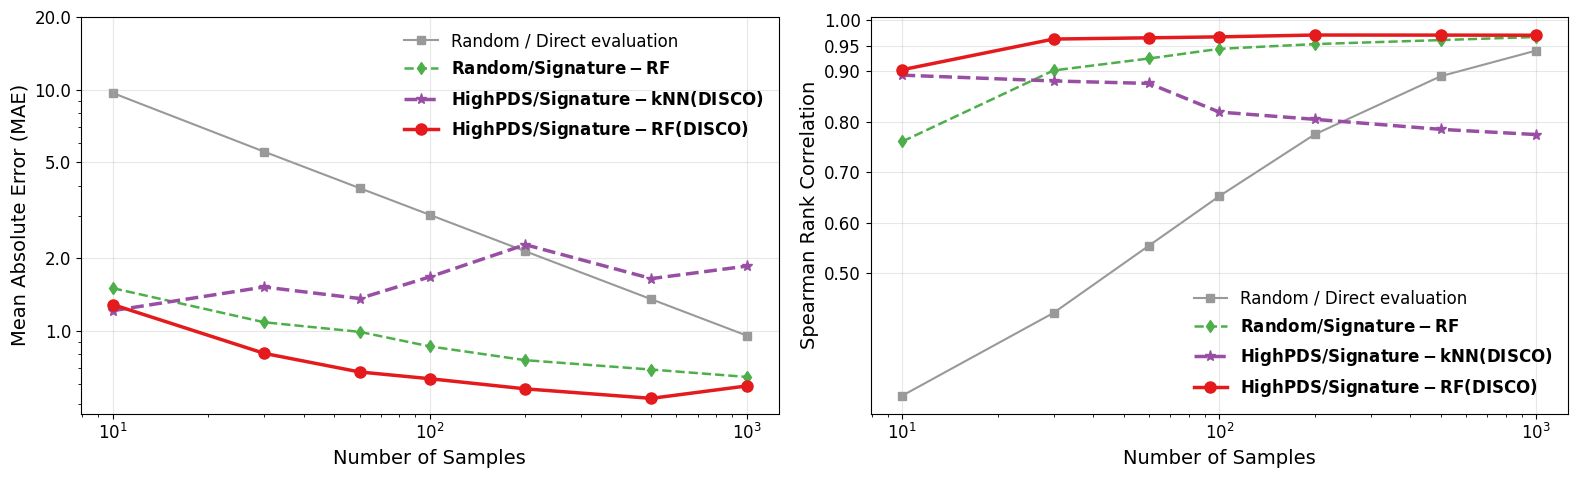

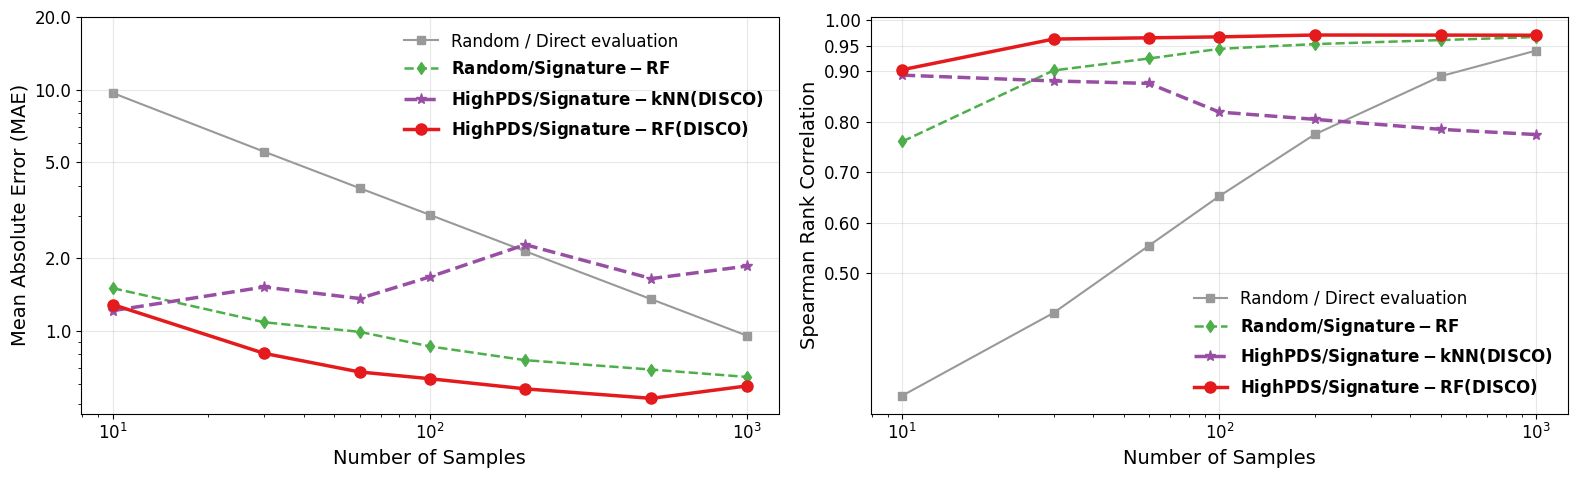

In [44]:
make_figure_n_anchors_hard_coded_v2(None, vision=True)